# Basic refnx tutorial

This notebook gives a brief tutorial on [`refnx`](https://github.com/refnx/refnx), a neutron and X-ray reflectometry analysis package. Further documentation and examples can be found at https://refnx.readthedocs.io/en/latest/, there are also video tutorials at https://www.youtube.com/channel/UCvhOxwZsdFMGqSzasE0ZSOw.

Python scripts always start off with importing the packages we need. Nearly all scientific scripts need numpy, the array manipulation package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from refnx.dataset import Data1D
from refnx.reflect import MaterialSLD, SLD, Slab, Structure, ReflectModel
from refnx.analysis import CurveFitter, Objective, Parameter

First of all we load the data into a Data1D object

In [2]:
data = Data1D('c_PLP0011859_q.txt')

In refnx a `Scatterer` describes the scattering length density of a material, `MaterialSLD` and `SLD` are the two types. `MaterialSLD` uses the the chemical formula of something, with a fittable density. Alternatively you can create an `SLD` object, which possesses a real and imaginary part.

In [3]:
# MaterialSLD uses a chemical formula and mass density
si = MaterialSLD('Si', 2.33)
sio2 = MaterialSLD('SiO2', 2.2)
d2o = MaterialSLD('D2O', 1.107)

# SLD uses a scattering length density. The SLD of polymer is (2.3 + 0j) * 10**-6
polymer = SLD(2.3 + 0j)

We're going to fit the SLD of the polymer, and the mass density of the SiO2. To do this we have to change properties of `Parameter` objects contained within the Scatterers.

In [4]:
sio2.density.setp(vary=True, bounds=(2.1, 2.2))
polymer.real.setp(vary=True, bounds=(1.0, 4.0))

Note that we could've also set up those objects like this:
```
sio2_density = Parameter(2.2, vary=True, bounds=(2.1, 2.2))
sio2 = MaterialSLD('SiO2', sio2_density)
```
An individual Parameter can be used in more that one place, and we'll use that now. In the next step we use a `Scatterer` to set up a [`Slab`](https://refnx.readthedocs.io/en/latest/refnx.reflect.html?highlight=Slab#refnx.reflect.Slab). A `Slab` is a type of `Component`, which describes a subset of our interface. A `Slab` has uniform scattering length density over its span. Here we're going to assume that the roughness of the polymer layer is roughly 3 Å. The roughness of a Slab is between that Slab and the preceding Component, that which is closer to the fronting material.

In [5]:
rough_par = Parameter(3, vary=True, bounds=(1, 10))

# create a Slab directly from the Scatterer. This slab has a thickness of 15 Å and a roughness of 3 Å.
sio2_l = sio2(15, 3)

# Alternative method of creating a Slab. Note how we used `rough_par`, the Parameter we created earlier.
polymer_l = Slab(200, polymer, rough_par)

We then create a `tructure`, which is a series of `Component` stacked together. Here the structure consists of:

Si $\longrightarrow$ $SiO_2$ $\longrightarrow$ polymer $\longrightarrow$ $D_2O$

The neutron beam is incident through the silicon, which is called the 'fronting' medium. The $D_2O$ is called the 'backing' medium. Note how we construct the $D_2O$ layer with `rough_par`. This means the $SiO_2$/polymer and polymer/$SiO_2$ interfaces share the same roughness parameter and will be identical in the fit. This Parameter sharing approach is commonly used in a multi-contrast fit.

In [6]:
# create a structure and model
structure = si | sio2_l | polymer_l | d2o(0, rough_par)

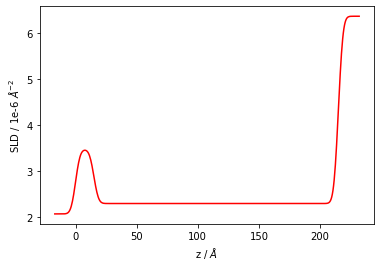

In [7]:
# quickly plot the SLD profile
structure.plot();

A `Structure` contains the details of the interfacial model, but in order to apply instrumental effects (such as resolution smearing) we need to place it in a `ReflectModel`. We're going to fit the scaling factor and the background. We're going to make the default dQ/Q resolution 4%.

In [8]:
scale = Parameter(1.0, vary=True, bounds=(0.8, 1.2))
bkg = Parameter(1.0e-6, vary=True, bounds=(1e-7, 1e-5))

model = ReflectModel(structure, scale=scale, bkg=bkg)
model.dq.value = 4.0

`ReflectModel` calculates the signal from the model.

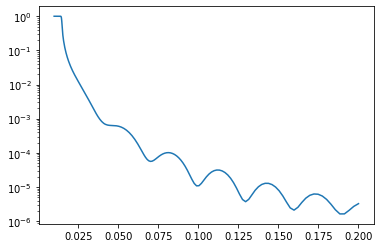

In [9]:
q = np.geomspace(0.01, 0.2, 201)
plt.plot(q, model(q))
plt.yscale('log')

Now we're going to set up the other Parameters we want to fit, and their limits.

In [10]:
# parameters we want to fit
sio2_l.thick.setp(vary=True, bounds=(5, 45))
polymer_l.thick.setp(vary=True, bounds=(200, 300))

An `Objective` combines the data and a model and is able to calculate various statistics like $\chi^2$, log-likelihood, etc. Multiple `Objective`s can be combined into a `GlobalObjective`, which is useful for fitting several datasets simultaneously.

In [11]:
objective = Objective(model, data)

Let's compare the data and the model:

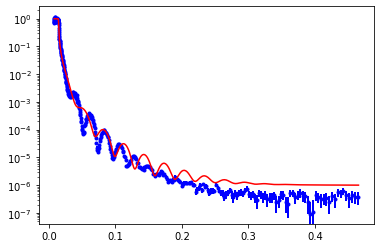

In [12]:
objective.plot()
plt.yscale('log')

In order to fit the data we have to create a CurveFitter with the objective.

In [13]:
fitter = CurveFitter(objective, ntemps=10)

In [14]:
fitter.fit('differential_evolution')

29it [00:04,  7.16it/s]


   covar: array([[ 8.06650306e-06,  1.97335180e-13, -8.07130423e-05,
         1.19047884e-06,  9.73349243e-05,  1.82991018e-05,
         2.53780275e-06],
       [ 1.97335180e-13,  3.34182591e-16, -9.65468885e-10,
         4.04473848e-12,  4.86446714e-10, -3.98268615e-11,
         9.56557315e-10],
       [-8.07130423e-05, -9.65468885e-10,  7.83838609e-02,
        -3.29520033e-04, -4.80685493e-02,  3.73563443e-05,
        -7.56845660e-03],
       [ 1.19047884e-06,  4.04473848e-12, -3.29520033e-04,
         4.28267955e-05,  2.84088293e-04,  4.05065475e-05,
         4.40285670e-06],
       [ 9.73349243e-05,  4.86446714e-10, -4.80685493e-02,
         2.84088293e-04,  3.87835547e-02,  2.89449122e-04,
         3.50999799e-03],
       [ 1.82991018e-05, -3.98268615e-11,  3.73563443e-05,
         4.05065475e-05,  2.89449122e-04,  1.39618435e-04,
        -4.69960964e-04],
       [ 2.53780275e-06,  9.56557315e-10, -7.56845660e-03,
         4.40285670e-06,  3.50999799e-03, -4.69960964e-04,
        

In [15]:
print(objective)

________________________________________________________________________________
Objective - 140308169285488
Dataset = c_PLP0011859_q
datapoints = 408
chi2 = 1084.731641834584
Weighted = True
Transform = None
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:     None      , value=0.876293 +/- 0.00284, bounds=[0.8, 1.2]>
<Parameter:     None      , value=4.5477e-07 +/- 1.83e-08, bounds=[1e-07, 1e-05]>
<Parameter:'dq - resolution', value=4 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=

After this fit the model matches the data well. Note that the roughnesses are the same for the last two interfaces, a consequence of them both using `rough_par`.

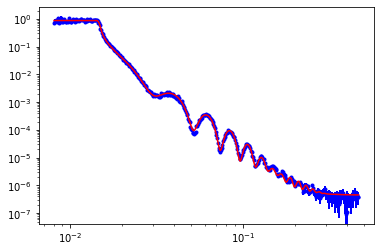

In [16]:
objective.plot()
plt.yscale('log')
plt.xscale('log')

Sampling using Markov Chain Monte Carlo is the most robust way of estimating Parameter uncertainties. Here we're doing Parallel Tempered MCMC (we set `ntemps=10` when creating the CurveFitter) to improve the chances of finding a global minimum, and also reduces the chain autocorrelation (a topic for a different tutorial). We 'burn' the first 100 samples because the samples may not distributed around the True mean (although this is unlikely as the fit is good). We thin the chain during the production run to reduce chain autocorrelation. A proper analysis needs to be done on chain statistics to understand each situation.

In [17]:
model.threads = 1
fitter.sample(100)
# we discard the first 100 steps.
fitter.reset()
# keep 2 samples, 100 steps apart.
fitter.sample(10, nthin=100);

100%|██████████| 1000/1000 [18:51<00:00,  1.13s/it]


Once you've done the sampling you can investigate the correlation between parameters using a corner plot. Here we see that the thickness of the $SiO_2$ layer is correlated with the thickness of the polymer layer

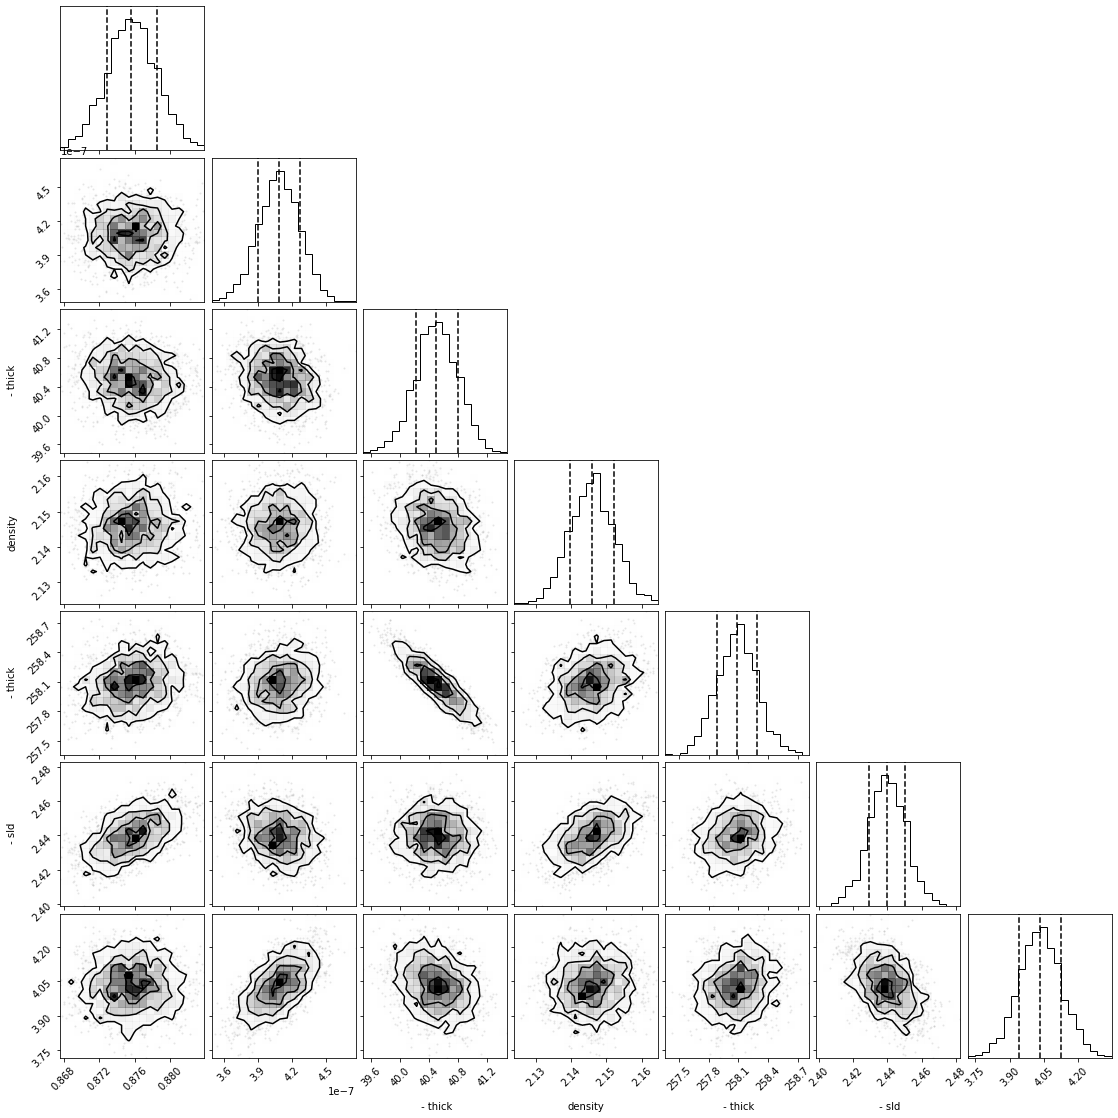

In [18]:
# plot the correlation between parameters
objective.corner();

In [19]:
print(objective)

________________________________________________________________________________
Objective - 140308169285488
Dataset = c_PLP0011859_q
datapoints = 408
chi2 = 1064.8599255770137
Weighted = True
Transform = None
________________________________________________________________________________
Parameters:       ''       
________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:     None      , value=0.875624 +/- 0.00278, bounds=[0.8, 1.2]>
<Parameter:     None      , value=4.08223e-07 +/- 1.87e-08, bounds=[1e-07, 1e-05]>
<Parameter:'dq - resolution', value=4 (fixed)  , bounds=[-inf, inf]>
<Parameter:  'q_offset'   , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bound

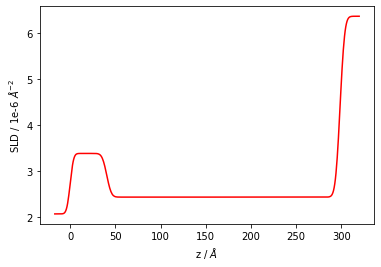

In [20]:
structure.plot();